In [164]:
%reload_ext autoreload
%autoreload 2
import os
from pathlib import Path
import numpy as np
import pandas as pd

In [165]:
data_dir = Path("/hits/fast/cme/bodynems/data/paper")
# sources = ["prefab4"]
sources = os.listdir(data_dir)
feat_dfs = []
label_dfs = []
for source in sources:
    # if source == "treebase_v1":
    #     continue
    feat_df = pd.read_parquet(data_dir / source / "features.parquet")
    label_df = pd.read_parquet(data_dir / source / "stats.parquet")
    label_df = label_df[["mean"]].query("method == 'dpos'").droplevel(2)
    feat_dfs.append(feat_df)
    label_dfs.append(label_df)

label_df = pd.concat(label_dfs, axis=0).sort_index()
feat_df = pd.concat(feat_dfs, axis=0).sort_index()
# feat_df = feat_df[top_feats[:20]]

if "is_dna" in feat_df:
    is_dna = feat_df.is_dna
    feat_df = feat_df.drop("is_dna", axis=1)
feat_df = feat_df.loc[:, ~feat_df.columns.str.endswith("monte-carlo-pi")]

assert (feat_df.index == label_df.index).all()

In [166]:
print("Shape:", feat_df.shape)
max_nan_col = feat_df.isna().sum().sort_values(ascending=False).iloc[[0]]
print("NaN max count: ", max_nan_col.index[0], "->", int(max_nan_col.iloc[0]))
print("NaN col share:", (feat_df.isna().any().mean()))
print(feat_df.columns[feat_df.isna().any()].to_list())
print()
print("NaN Rows:")
nan_mask = feat_df.isna().any(axis=1)
feat_df[nan_mask]

Shape: (6567, 101)
NaN max count:  p25:tc_max -> 5
NaN col share: 0.32673267326732675
['min:tc_min', 'max:tc_min', 'mean:tc_min', 'std:tc_min', 'p5:tc_min', 'p10:tc_min', 'p25:tc_min', 'p50:tc_min', 'p75:tc_min', 'p90:tc_min', 'p95:tc_min', 'min:tc_mean', 'max:tc_mean', 'mean:tc_mean', 'std:tc_mean', 'p5:tc_mean', 'p10:tc_mean', 'p25:tc_mean', 'p50:tc_mean', 'p75:tc_mean', 'p90:tc_mean', 'p95:tc_mean', 'min:tc_max', 'max:tc_max', 'mean:tc_max', 'std:tc_max', 'p5:tc_max', 'p10:tc_max', 'p25:tc_max', 'p50:tc_max', 'p75:tc_max', 'p90:tc_max', 'p95:tc_max']

NaN Rows:


num_seqs  min:seq_length  max:seq_length  \
source  dataset                                                 
prefab4 1aerA_1aerB         2             195             204   
        1aqzA_1de3A         2             142             150   
        1bcpD_1prtF         2              98             109   
        1be3C_3bccC         2             379             379   
        1hx1B_2a3dA         2              73             112   

                     mean:seq_length  std:seq_length  p5:seq_length  \
source  dataset                                                       
prefab4 1aerA_1aerB            199.5             4.5         195.45   
        1aqzA_1de3A            146.0             4.0         142.40   
        1bcpD_1prtF            103.5             5.5          98.55   
        1be3C_3bccC            379.0             0.0         379.00   
        1hx1B_2a3dA             92.5            19.5          74.95   

                     p10:seq_length  p25:seq_length  p50:seq_length  \
source  dataset                                                       
prefab4 1aerA_1aerB           195.9          197.25           199.5   
        1aqzA_1de3A           142.8          144.00           146.0   
        1bcpD_1prtF            99.1          100.75           103.5   
        1be3C_3bccC           379.0          379.00           379.0   
        1hx1B_2a3dA            76.9           82.75            92.5   

                     p75:seq_length  ...  max:tc_max  mean:tc_max  std:tc_max  \
source  dataset                      ...                                        
prefab4 1aerA_1aerB          201.75  ...         NaN          NaN         NaN   
        1aqzA_1de3A          148.00  ...         NaN          NaN         NaN   
        1bcpD_1prtF          106.25  ...         NaN          NaN         NaN   
        1be3C_3bccC          379.00  ...         NaN          NaN         NaN   
        1hx1B_2a3dA          102.25  ...         NaN          NaN         NaN   

                     p5:tc_max  p10:tc_max  p25:tc_max  p50:tc_max  \
source  dataset                                                      
prefab4 1aerA_1aerB        NaN         NaN         NaN         NaN   
        1aqzA_1de3A        NaN         NaN         NaN         NaN   
        1bcpD_1prtF        NaN         NaN         NaN         NaN   
        1be3C_3bccC        NaN         NaN         NaN         NaN   
        1hx1B_2a3dA        NaN         NaN         NaN         NaN   

                     p75:tc_max  p90:tc_max  p95:tc_max  
source  dataset                                          
prefab4 1aerA_1aerB         NaN         NaN         NaN  
        1aqzA_1de3A         NaN         NaN         NaN  
        1bcpD_1prtF         NaN         NaN         NaN  
        1be3C_3bccC         NaN         NaN         NaN  
        1hx1B_2a3dA         NaN         NaN         NaN  

[5 rows x 101 columns]

In [167]:
mask = (feat_df["num_seqs"] >= 3).to_numpy()
print(f"Dropping {sum(~mask)} NaN rows...")
feat_df = feat_df[mask]
label_df = label_df[mask]

Dropping 5 NaN rows...


In [168]:
print(feat_df.num_seqs.max())
print(feat_df["max:seq_length"].max())

233
7954


In [169]:
sample = np.random.randint(0, len(label_df), int(len(label_df) * 0.7))
train_idxs = label_df.iloc[sample].index
test_idxs = feat_df.drop(feat_df.iloc[sample].index).index
assert len(set(train_idxs).intersection(set(test_idxs))) == 0

In [ ]:
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
)
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector

# selector = SequentialFeatureSelector(
#     LinearRegression(), n_features_to_select=30
# )
model = HistGradientBoostingRegressor(
    max_features=0.1,
    max_depth=7,
    # learning_rate=0.05,
    max_leaf_nodes=None,
    max_iter=100,
    # loss="absolute_error",
)
model = RandomForestRegressor(
    max_features=0.1,
    max_depth=7,
    # learning_rate=0.05,
    max_leaf_nodes=None,
    # max_iter=100,
    # loss="absolute_error",
)
# model = LinearRegression()
# pipeline = Pipeline([("select", selector), ("model", model)])
pipeline = Pipeline([("model", model)])
# model = GradientBoostingRegressor()
# model = LinearRegression()
pipeline.fit(feat_df.loc[train_idxs], label_df.loc[train_idxs].to_numpy().ravel())
y_pred = pipeline.predict(feat_df.loc[test_idxs])

In [171]:
y_true = label_df.loc[test_idxs].to_numpy().ravel()
rmse = (((y_pred - y_true) ** 2).sum() / len(y_true)) ** 0.5
corr = np.corrcoef(y_true, y_pred)[0, 1]
print(f"[RMSE] {rmse:.4f}")
print(f"[CORR] {corr:.4f}")

[RMSE] 0.0544
[CORR] 0.9480


Text(0, 0.5, 'Label')

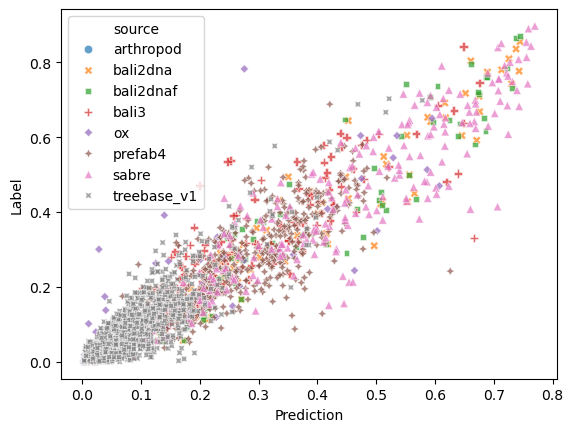

In [172]:
import seaborn as sn
import matplotlib.pyplot as plt

sources = feat_df.loc[test_idxs].reset_index().loc[:, "source"]
sn.scatterplot(x=y_pred, y=y_true, alpha=0.7, style=sources, hue=sources)
plt.xlabel("Prediction")
plt.ylabel("Label")
# sn.scatterplot(
#     x=y_pred,
#     y=y_true,
#     alpha=0.5,
#     style=sources,
#     hue=is_dna.loc[test_idxs].reset_index(drop=True),
# )

Text(0.5, 0, 'Features')

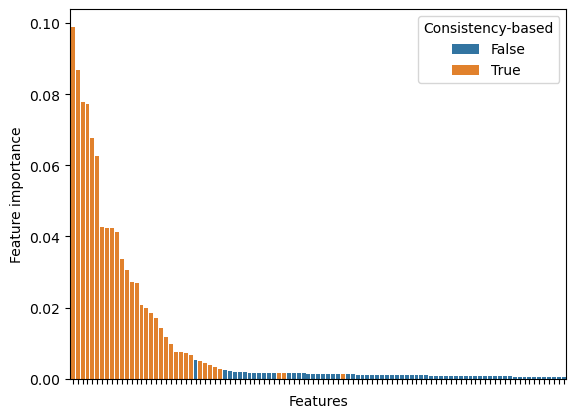

In [173]:
importance = model.feature_importances_
sort_idxs = np.argsort(importance)[::-1]
top_feats = feat_df.columns[sort_idxs]
is_tc = top_feats.str.contains("tc_")
sn.barplot(x=top_feats, y=importance[sort_idxs], hue=is_tc)
ax = plt.gca()
_ = ax.set_xticklabels([])
ax.legend(title="Consistency-based")
ax.set_ylabel("Feature importance")
ax.set_xlabel("Features")